read data done
./pic/22.jpg
read pic time: 0.1324474811553955 s
locatePlate pic time: 0.5884130001068115 s
accessPlate time: 1.4553892612457275 s
accessPlate time: 2.9916460514068604 s
all time cost: 4.265160799026489 s



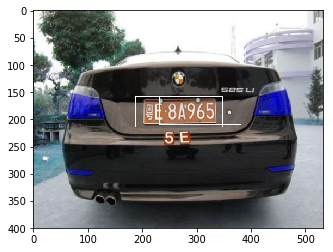

./pic/1.jpg
read pic time: 0.16635489463806152 s
locatePlate pic time: 0.6136744022369385 s
accessPlate time: 1.6436264514923096 s
splitPlate time: 1.7927637100219727 s
recognize time: 2.6535747051239014 s
accessPlate time: 3.491579532623291 s
all time cost: 5.146068096160889 s
NingXiaAA969N7


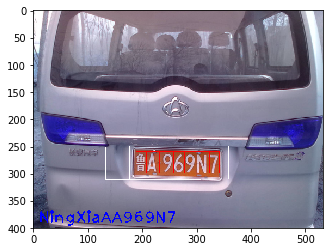

./pic/2.jpg
read pic time: 0.16835880279541016 s
locatePlate pic time: 0.6145000457763672 s
accessPlate time: 1.7707252502441406 s
all time cost: 4.132661581039429 s



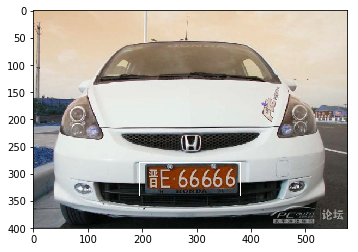

./pic/3.jpg
read pic time: 0.2880091667175293 s
locatePlate pic time: 0.6953701972961426 s
accessPlate time: 1.4067928791046143 s
splitPlate time: 3.9416537284851074 s
recognize time: 4.682568073272705 s
all time cost: 4.684699058532715 s
SiChuanA99996


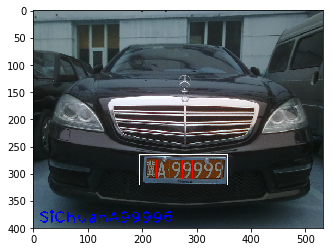

In [4]:
import cv2
import numpy as np
import math
from PIL import Image, ImageDraw, ImageFont 
from matplotlib import pyplot as plt
import time
import os


Hmin=100
Hmax=124
Smin=120
Smax=255
Vmin=120
Vmax=255

#精确的定位车牌
def locateAccuracy(img):
    frame=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    height = frame.shape[0]
    width = frame.shape[1]
    top=0
    button=height-1
    left=0
    right=width-1

    row=0
    while(row<height):
        col=0
        count=0
        while(col<width):
            if((frame[row,col,0]>=Hmin and frame[row,col,0]<=Hmax) and (frame[row,col,1]>=Smin and frame[row,col,1]<=Smax) and (frame[row,col,2]>=Vmin and frame[row,col,2]<=Vmax)):
                count+=1
            col+=1
        if(count/width>0.6):
            top=row
            break
        row+=1

    row=button
    while(row>0):
        col=0
        count=0
        while(col<width):
            if((frame[row,col,0]>=Hmin and frame[row,col,0]<=Hmax) and (frame[row,col,1]>=Smin and frame[row,col,1]<=Smax) and (frame[row,col,2]>=Vmin and frame[row,col,2]<=Vmax)):
                count+=1
            col+=1
        if(count/width>0.6):
            button=row
            break
        row-=1

    col=right
    while(col>0):
        row=0
        count=0
        while(row<height):
            if((frame[row,col,0]>=Hmin and frame[row,col,0]<=Hmax) and (frame[row,col,1]>=Smin and frame[row,col,1]<=Smax) and (frame[row,col,2]>=Vmin and frame[row,col,2]<=Vmax)):
                count+=1
            row+=1
        if(count/height>0.6):
            right=col
            break
        col-=1
    col=left
    while(col<width):
        row=0
        count=0
        while(row<height):
            if((frame[row,col,0]>=Hmin and frame[row,col,0]<=Hmax) and (frame[row,col,1]>=Smin and frame[row,col,1]<=Smax) and (frame[row,col,2]>=Vmin and frame[row,col,2]<=Vmax)):
                count+=1
            row+=1
        if(count/height>0.6):
            left=col
            break
        col+=1
    return top,button,left,right

def recognize(img):
    top,button,left,right=locateAccuracy(img)
    image=img[top:button,left:right]
    if(image.size==0):
        return []
    img_gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img_thre=cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,35,2)#自适应二值化
    #对对图像进行垂直投影
    arr=np.zeros(image.shape[1])
    col=0
    while(col<img_thre.shape[1]):
        row=0
        count=0
        while(row<img_thre.shape[0]):
            count+=img_thre[row,col]
            row+=1
        arr[col]=int(count/255)
        col+=1
    #根据投影结果进行分割字符
    count_1=0
    flag=0
    flag_index=0
    i=0
    for c in arr:
        if(c<11):
            count_1+=1
        else:
            if(count_1>flag):
                flag=count_1
                flag_index=int(i-count_1/2)
            if(count_1>3):
                arr[int(i-count_1/2)]=-1
            count_1=0
        i+=1
    i=0
    j=0
    x=0
    y=top
    h=button-top

    #获得分割结果
    charList=[]
    for c in arr:
        if(c==-1):
            w=i-x
            charList.append([x+left,y,w,h])
            x=i
        if(flag_index==c and (j!=1 or j!=2)):
            return []

        i+=1
        j+=1
    charList.append([x+left,y,right-x,h])
    if(len(charList)<5 or len(charList)>8):
        return []
    return charList

def recognizeRect(img_thre,rect,knn):
    x,y,w,h=rect
    roi=img_thre[y:(y+h),x:(x+w)]
    if h>w:
        roi=cv2.copyMakeBorder(roi,0,0,int((h-w)/2),int((h-w)/2),cv2.BORDER_CONSTANT,value=[0,0,0])
    roi=cv2.resize(roi,(20,20))
    #cv2.imshow("char",roi)
    #cv2.waitKey(0)
    roivector=roi.reshape(1,400).astype(np.float32)
    ret,result,neighbours,dist=knn.findNearest(roivector,k=6)#进行预测
    return int(ret)

def access_pixels(frame):
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    #print(frame.shape)  #shape内包含三个元素：按顺序为高、宽、通道数
    height = frame.shape[0]
    weight = frame.shape[1]
    count=0
    for row in range(height):            #遍历高
        for col in range(weight):         #遍历宽
            if((frame[row,col,0]>=100 and frame[row,col,0]<=124) and (frame[row,col,1]>=43 and frame[row,col,1]<=255) and (frame[row,col,2]>=46 and frame[row,col,2]<=255)):
                count+=1
    if(count/(height*weight)>0.5):
        return True
    else:
        return False

def isPlate(frame):
    if(frame.shape[1]>frame.shape[0]/2 or frame.shape[1]*5<frame.shape[0]):
        return True
    else:
        return False


if __name__ == '__main__':
    #读取字典和数据        
    with open('knn_dict_letter.txt','r') as f:
        labelDict = eval(f.read())
    with np.load('knn_data.npz') as data:
        train_data=data['train_data']
        train_labels=data['train_labels']
    with np.load('knn_data_zh.npz') as data:
        train_data_zh=data['train_data_zh']
        train_labels_zh=data['train_labels_zh']
    
    print('read data done')

    # 定义分类器
    cascade_path = 'cascade.xml'
    cascade_car_path = 'cars.xml'
    car_cascade = cv2.CascadeClassifier(cascade_car_path)
    cascade = cv2.CascadeClassifier(cascade_path)
    

    #image=cv2.imread("pic//8.jpg")
    #cap = cv2.VideoCapture('video//2.mp4')

    baseDir="./pic/"
    #获取该目录下的所有文件
    fileList=os.listdir(baseDir)
    n=0
    for i in fileList:
        time_start=time.time()
        print(baseDir+i)
        image=cv2.imread(baseDir+i)

#    while (cap.isOpened()):    
#        ret, image = cap.read()
#        if(ret==False):
#            break
        resize_h = 400
        height = image.shape[0]
        scale = image.shape[1] / float(height)
        image = cv2.resize(image, (int(scale * resize_h), resize_h))

        # 转为灰度图
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        img_thre=cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,35,2)#自适应二值化
        print('read pic time:',time.time()-time_start,'s')

        #车辆定位
#        cars = car_cascade.detectMultiScale(image_gray, 1.1, 1)
#        for (x,y,w,h) in cars:
#            cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)

        # 车牌定位
        car_plates = cascade.detectMultiScale(image_gray, 1.1, 2, minSize=(36, 9), maxSize=(36 * 40, 9 * 40))
        print('locatePlate pic time:',time.time()-time_start,'s')
        
    
        #print('time cost:',time.time()-time_start,'s')
        #print("检测到车牌数", len(car_plates))
        #遍历粗定位的车牌
        str_plate=''
        if len(car_plates) > 0:
            for car_plate in car_plates:
                x, y, w, h = car_plate
                plate = image[y: y + h, x: x + w]
                if(isPlate(plate)==False):#根据颜色判断是否是正确的车牌区域
                    continue
                if(access_pixels(plate)==False):#根据颜色判断是否是正确的车牌区域
                    continue
                print('accessPlate time:',time.time()-time_start,'s')
                #print('time cost:',time.time()-time_start,'s')
                #标出粗定位的车牌
                cv2.rectangle(image, (x - 10, y - 10), (x + w + 10, y + h + 10), (255, 255, 255), 1)
                #分割字符
                charRect=recognize(image[y: y + h, x: x + w])
                #charRect=[]
                #print('time cost:',time.time()-time_start,'s')

                if(len(charRect)==0):
                    continue
                    
                print('splitPlate time:',time.time()-time_start,'s')

                #模型创建
                knn_zh=cv2.ml.KNearest_create()
                knn_zh.train(train_data_zh,cv2.ml.ROW_SAMPLE,train_labels_zh)
                #识别中文
                rect=charRect[0]
                x1,y1,w1,h1=rect
                x1=x+x1
                y1=y+y1
                str_plate=labelDict[recognizeRect(img_thre,(x1,y1,w1,h1),knn_zh)]
                
                knn=cv2.ml.KNearest_create()
                knn.train(train_data,cv2.ml.ROW_SAMPLE,train_labels)
                for rect in charRect[1:]:
                    x1,y1,w1,h1=rect
                    x1=x+x1
                    y1=y+y1
                    cv2.rectangle(image,(x1,y1),(x1+w1,y1+h1),(255,0,0),1)#框出字块
                    s=labelDict[recognizeRect(img_thre,(x1,y1,w1,h1),knn)]
                    str_plate=str_plate+s
                print('recognize time:',time.time()-time_start,'s')
        image=cv2.putText(image,str_plate,(10,image.shape[0]-10),cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
        print('all time cost:',time.time()-time_start,'s')
        print(str_plate)
        %matplotlib inline
        plt.imshow(image)
        plt.show()
